In [35]:
!pip install h5py
import h5py
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
import cv2

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [14]:
def load_image_from_h5(filepath):
    """
    Load an image from an HDF5 file.
    
    Parameters:
    - filepath: str, path to the HDF5 file
    
    Returns:
    - image: numpy array of the loaded image
    """
    with h5py.File(filepath, 'r') as f:
        image = f['image1']['image_data'][...]
    return image

In [36]:
def display_cropped_image(image, x_start, y_start, crop_width, crop_height):
    """
    Display a cropped portion of the image.
    
    Parameters:
    - image: numpy array of the original image
    - x_start, y_start: int, coordinates of the top-left corner of the crop
    - crop_width, crop_height: int, width and height of the crop
    """
    cropped = image[y_start:y_start + crop_height, x_start:x_start + crop_width]
    mask_image = cropped.copy()
    mask_image[mask_image != 65535] = 1
    mask_image[mask_image == 65535] = 0
    mask_image = cv2.resize(mask_image, (64, 64), interpolation=cv2.INTER_AREA)
    output_file = "mask.npy"
    np.save(output_file, mask_image)
    print(f"Mask saved to {output_file}")
    
    plt.imshow(mask_image, cmap='viridis')
    plt.axis('off')
    plt.show()

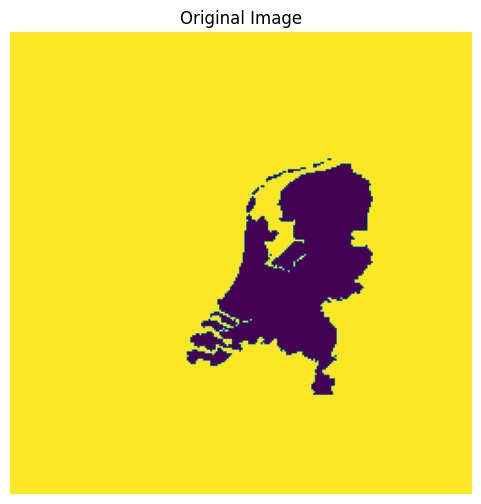

In [37]:
# Load your image
filepath = 'data/precipitation/rain_maps/2017/05/RAD_NL21_RAC_MFBS_5min_201705010000_NL.h5'  # Replace with the path to your HDF5 file
image = load_image_from_h5(filepath)

# Display the original image
plt.figure(figsize=(6, 6))
plt.imshow(image, cmap='viridis')
plt.title("Original Image")
plt.axis('off')
plt.show()

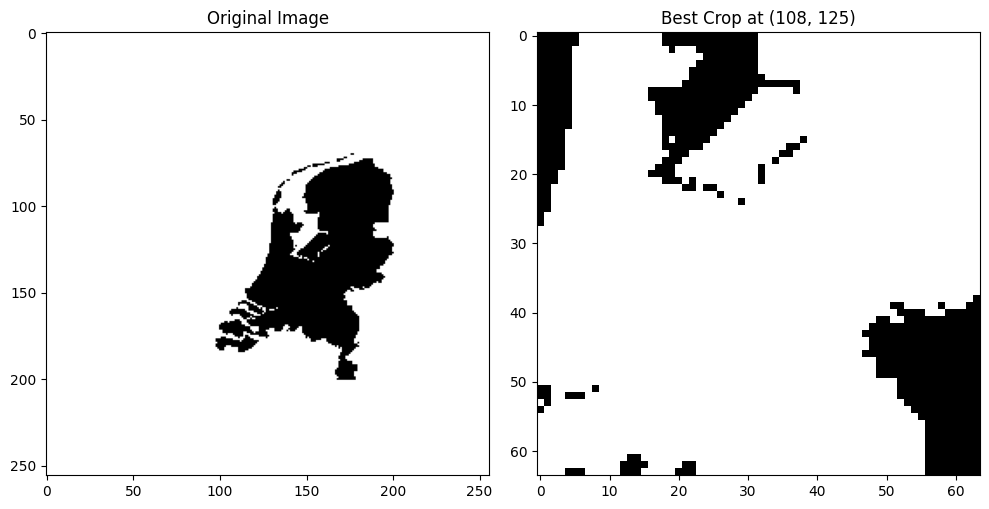

In [43]:
import numpy as np
import matplotlib.pyplot as plt

def best_crop(image, crop_size=(64, 64)):
    """
    Find the best crop of size `crop_size` in the given `image` based on maximizing the sum of pixel values.
    
    :param image: The input image (2D numpy array).
    :param crop_size: The size of the crop (default is 64x64).
    :return: The best 64x64 crop.
    """
    h, w = image.shape
    crop_h, crop_w = crop_size
    
    # Initialize the best sum and coordinates
    best_sum = -np.inf
    best_crop = None
    best_coords = (0, 0)
    image = image < 60000
    image.reshape((256,256))
    
    # Iterate through all possible crop positions
    for i in range(h - crop_h + 1):
        for j in range(w - crop_w + 1):
            # Extract the current crop
            crop = image[i:i + crop_h, j:j + crop_w]
            crop_sum = np.sum(crop)  # You can change this criterion to something else (e.g., variance)
            
            # Update if the current crop has a higher sum
            if crop_sum > best_sum:
                best_sum = crop_sum
                best_crop = crop
                best_coords = (i, j)
    
    return best_crop, best_coords


def show_crop(image, crop, coords):
    """
    Display the original image and the best crop.

    :param image: The original image.
    :param crop: The best 64x64 crop.
    :param coords: The coordinates (top-left corner) of the crop in the original image.
    """
    # Plot original image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    
    # Plot the crop
    plt.subplot(1, 2, 2)
    plt.imshow(crop, cmap='gray')
    plt.title(f'Best Crop at {coords}')
    
    plt.tight_layout()
    plt.show()


# Example Usage:
# image is already a 2D NumPy array (e.g., loaded from elsewhere)
# image = np.array(...)  # Your image as a 2D NumPy array

# Find the best 64x64 crop
best_crop, best_coords = best_crop(image)

# Show the original image and the best crop
show_crop(image, best_crop, best_coords)

In [24]:
# Define maximum slider values based on image dimensions
max_x, max_y = image.shape[1], image.shape[0]

# Interactive cropping tool
@interact(
    x_start=IntSlider(0, 0, max_x - 1, description='X Start'),
    y_start=IntSlider(0, 0, max_y - 1, description='Y Start'),
    crop_width=IntSlider(64, 1, max_x, description='Crop Width'),
    crop_height=IntSlider(64, 1, max_y, description='Crop Height')
)
def interactive_cropping(x_start, y_start, crop_width, crop_height):
    """
    Interactively crop the image using sliders.
    """
    # Ensure crop dimensions don't exceed the image boundaries
    if x_start + crop_width > max_x:
        crop_width = max_x - x_start
    if y_start + crop_height > max_y:
        crop_height = max_y - y_start
    
    display_cropped_image(image, x_start, y_start, crop_width, crop_height)

interactive(children=(IntSlider(value=0, description='X Start', max=255), IntSlider(value=0, description='Y St…